# <center> FITS Comparison

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys
import math
sys.path.append('..')  # add parent directory to path to import utils
from utils import set_plots_size_params
import pyabc
import os
import scipy.stats as st
import pandas as pd
import subprocess
import time

In [2]:
def wf_with_selection_and_mutation(wt_freq, population_size, fitness, mutation_rate, sequence_sample_size):
    # math from https://academic.oup.com/sysbio/article/66/1/e30/2670014#syw056M2 
    wt_freq = wt_freq*(1 - mutation_rate) + (1 - wt_freq)*mutation_rate                  # mutation
    wt_freq = (wt_freq * fitness) / ( (1-wt_freq) + (wt_freq * fitness))                 # selection
    wt_freq = np.random.binomial(population_size, wt_freq) / population_size             # bottleneck
    return wt_freq
    
    
def wt_generations(generations_number, wt_freq, population_size, fitness, mutation_rate, sequence_sample_size, 
                   color=None, label=None, plot=True):
    freqs = []
    for i in range(generations_number):
        wt_freq = wf_with_selection_and_mutation(wt_freq=wt_freq, population_size=population_size, 
                                                 fitness=fitness, mutation_rate=mutation_rate, 
                                                 sequence_sample_size=sequence_sample_size)
        freqs.append(wt_freq)
    freqs = np.random.binomial(sequence_sample_size, freqs) / sequence_sample_size   # sequence sampling
    if plot:
        plt.plot(range(generations_number), freqs, color=color, label=label, alpha=0.1)
    return np.array(freqs)


def simulate_50(generations_number, wt_freq, population_size, fitness, mutation_rate, sequence_sample_size, 
                 color=None, label=None, plot=True):
    if plot:
        plt.xlabel('Generation')
        plt.ylabel('Frequency')
    data = []
    for i in range(50):
        datum = wt_generations(generations_number=generations_number, wt_freq=wt_freq, plot=plot,
                               population_size=population_size, fitness=fitness, mutation_rate=mutation_rate, 
                               color=color,  sequence_sample_size=sequence_sample_size, 
                               label=label if i==0 else None)
        data.append(datum)
    if label:
        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    return pd.DataFrame(data)

In [45]:
def pyFITS(prior_dist, data, simulation_num, params, top_fraction):
    values = []
    for i in range(simulation_num):
        prior = 10**prior_dist.rvs()['x']
        sym = wt_generations(mutation_rate=prior, generations_number=params['gen'], wt_freq=params['freq0'], 
                             population_size=params['pop'], fitness=params['fit'], 
                             sequence_sample_size=params['ss'], plot=False)
        distance = abs(sym-data).sum()
        values.append({'distance': distance, 'post': prior})
    df = pd.DataFrame.from_records(values).sort_values('distance')
    df = df.head(int(simulation_num * top_fraction))
    df['log_post'] = np.log10(df['post'])
    return df

def pyFITS_fitness(prior_dist, data, simulation_num, params, top_fraction):
    values = []
    for i in range(simulation_num):
        prior = prior_dist.rvs()['x']
        sym = wt_generations(fitness=prior, mutation_rate=params['mut'], generations_number=params['gen'], 
                             wt_freq=params['freq0'], population_size=params['pop'], 
                             sequence_sample_size=params['ss'], plot=False)
        distance = abs(sym-data).sum()
        values.append({'distance': distance, 'post': prior})
    df = pd.DataFrame.from_records(values).sort_values('distance')
    df = df.head(int(simulation_num * top_fraction))
    df['log_post'] = df['post']
    return df

In [18]:
def run_pyFITS(prior_dist, data, num_sim, top_fraction, model_params, fitness=False):
    start = time.time()
    if fitness:
        post = pyFITS_fitness(prior_dist, data, num_sim, model_params, top_fraction)
    else:
        post = pyFITS(prior_dist, data, num_sim, model_params, top_fraction)
    print("pyFITS run time ", round(time.time()-start,2))
    print(f"pyFITS Created posterior from {len(post)} results")
    print(f"pyFITS max epsilon: {post.distance.max()}")
    return post

In [19]:
def smc_model(parameters):
    pop_size = 100000000
    gen_num = 10
    sample_size = 100000
    intial_freq = 0
    mutation_rate = 10**parameters['x']
    fitness = 1
    return {'a': wt_generations(generations_number=gen_num,  wt_freq=intial_freq, population_size=pop_size, 
                          mutation_rate=mutation_rate, fitness=fitness, sequence_sample_size=sample_size, 
                          plot=False, color=False, label=False)}

def smc_model_fit01(parameters):
    pop_size = 100000000
    gen_num = 10
    sample_size = 100000
    intial_freq = 0
    mutation_rate = 10**parameters['x']
    fitness = 1.01
    return {'a': wt_generations(generations_number=gen_num,  wt_freq=intial_freq, population_size=pop_size, 
                          mutation_rate=mutation_rate, fitness=fitness, sequence_sample_size=sample_size, 
                          plot=False, color=False, label=False)} 


def smc_model_fitness(parameters):
    pop_size = 100000000
    gen_num = 10
    sample_size = 100000
    intial_freq = 0
    mutation_rate = 0.0007
    fitness = parameters['x']
    return {'a': wt_generations(generations_number=gen_num,  wt_freq=intial_freq, population_size=pop_size, 
                          mutation_rate=mutation_rate, fitness=fitness, sequence_sample_size=sample_size, 
                          plot=False, color=False, label=False)}

In [20]:
def plot_smc(smc_out):
    fig, ax = plt.subplots()
    for t in range(smc_out.max_t+1):
        df, w = smc_out.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df, w,
            x="x", ax=ax,
            label="PDF t={}".format(t))
    ax.legend(bbox_to_anchor=(1, 1))
    plt.show()


In [21]:
def last_freq_L1(simulation, data):
    return abs(data['a'] - simulation['a']).sum()

def run_smc(priors, data, epsilon, fitness=False):
    start = time.time()
    if fitness == 1.01:
        model = smc_model_fit01
    elif fitness:
        model = smc_model_fitness
    else:
        model = smc_model
    abc = pyabc.ABCSMC(
            model, priors,
            last_freq_L1, population_size=1000, sampler=pyabc.sampler.SingleCoreSampler())
    db_path = ("sqlite:///test.db")
    smc_post = abc.new(db_path, {'a': data})
    smc_post = abc.run(minimum_epsilon=epsilon, max_nr_populations=10)
    print("SMC run time: ", round(time.time()-start,2))
    print("Total number of SMC simulations: ", smc_post.total_nr_simulations)
    plot_smc(smc_post)
    return smc_post

In [ ]:
def plot_kdes(smc_output, pyFITS_output, FITS_output, real_value, fitness=False):
    if not fitness:
        real_value = math.log10(real_value)
    fig, ax = plt.subplots()
    df, w = smc_output.get_distribution(m=0)
    pyabc.visualization.plot_kde_1d(
        df, w, 
        x="x", ax=ax,
        label="ABCSMC")
    if not fitness:
        real_value = 10**real_value
    ax.axvline(real_value, color="k", linestyle="dashed")
    pyabc.visualization.plot_kde_1d(
        pyFITS_output, np.ones(len(pyFITS_output))/len(pyFITS_output), label='pyFITS', x='log_post', ax=ax)
    ax.axvline(real_value, color="k", linestyle="dashed")
    pyabc.visualization.plot_kde_1d(
        FITS_output, np.ones(len(FITS_output))/len(FITS_output), label='FITS', x='log', ax=ax)
    plt.title('Posterior')
    plt.legend()
    if fitness:
        plt.xlabel('fitness')
    else:
        plt.xlabel('log mutation rate')
    return fig, ax

In [33]:
def create_fits_input_data(data):
    outfile = 'fits_input_data.tsv'
    fits = dict()
    fits['mut'] = pd.DataFrame(data={'freq': data})
    fits['wt'] = pd.DataFrame(data={'freq': 1-data})
    fits['mut']['allele'] = 1
    fits['wt']['allele'] = 0
    fits_input = pd.concat(fits.values()).reset_index().rename(columns={'index': 'gen'})
    fits_input=fits_input[['gen','allele','freq']]
    fits_input.to_csv(outfile, index=False, sep='\t')
    return outfile
    
def run_FITS(data, params_file=None, fitness=False):
    """FITS params need to be edited manually"""
    input_data_file = create_fits_input_data(data)
    if fitness:
        run_type = 'fitness'
        if not params_file:
            params_file = "../FITS/params_f01_mr734.txt"
        
    else:
        run_type = 'mutation'
        if not params_file:
            params_file = "../FITS/parameters.txt"
    cmd = f"./../FITS/fits1.3.3 -{run_type} {params_file} {input_data_file} fits_post.tsv fits_sum.txt"
    start = time.time()
    subprocess.run(cmd.split())
    print("FITS run time: ", round(time.time()-start,2))
    fits_post = pd.read_table('fits_post.tsv')
    if fitness:
        fits_post['log'] = fits_post['allele1']
    else:
        fits_post['log'] = np.log10(fits_post['allele0_1'])
    return fits_post

In [34]:
def compare_pyFITS(mutation_rate, prior_edges=[-7,-2], num_sim=100000, top_fraction=0.01, 
                   params_file=None, fitness=1):
    params = {'gen': 10, 'freq0':0, 'pop': 100000000, 'ss': 100000, 'fit': fitness}
    print("Creating dataset...")
    data = simulate_50(generations_number=params['gen'], wt_freq=params['freq0'],  mutation_rate=mutation_rate,
                       population_size=params['pop'], fitness=params['fit'], sequence_sample_size=params['ss'], 
                             plot=False).mean()
    prior_dist = pyabc.Distribution(x=pyabc.RV("uniform", prior_edges[0], prior_edges[1]-prior_edges[0]))
    print("running pyFits...")
    pyfits_out = run_pyFITS(prior_dist, data, num_sim, top_fraction, params)
    print("Running FITS...")
    fits_out = run_FITS(data, params_file)
    print("FITS max distance: ", fits_out['distance'].max())
    print("pyFITS max distance: ", pyfits_out['distance'].max())
    epsilon = pyfits_out['distance'].max()
    print("Running SMC with epsilon: ", epsilon)
    smc_out = run_smc(prior_dist, data, epsilon, fitness)
    return plot_kdes(smc_out, pyfits_out, fits_out, mutation_rate)
    

In [38]:
def compare_fitness_inference(fitness,  num_sim=100000, top_fraction=0.01,  params_file=None, 
                              mutation_rate=0.0007):
    params = {'gen': 10, 'freq0':0, 'pop': 100000000, 'ss': 100000, 'fit': fitness, 'mut': mutation_rate}
    print("Creating dataset...")
    data = simulate_50(generations_number=params['gen'], wt_freq=params['freq0'],  mutation_rate=params['mut'],
                       population_size=params['pop'], fitness=params['fit'], sequence_sample_size=params['ss'], 
                       plot=False).mean()
    prior_dist = pyabc.Distribution(x=pyabc.RV("uniform", 0, 2))
    print("running pyFits...")
    pyfits_out = run_pyFITS(prior_dist, data, num_sim, top_fraction, params, fitness=True)
    print("Running FITS...")
    fits_out = run_FITS(data, params_file, fitness=True)
    print("FITS max distance: ", fits_out['distance'].max())
    print("pyFITS max distance: ", pyfits_out['distance'].max())
    epsilon = pyfits_out['distance'].max()
    print("Running SMC with epsilon: ", epsilon)
    smc_out = run_smc(prior_dist, data, epsilon, fitness=True)
    return plot_kdes(smc_out, pyfits_out, fits_out, fitness, fitness=True)

# Comparing fitness inference

Creating dataset...
running pyFits...
pyFITS run time  41.06
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.0021444000000000007
Running FITS...


INFO:History:Start <ABCSMC(id=162, start_time=2021-02-09 16:02:32.472746, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  2.68
FITS max distance:  0.00369313
pyFITS max distance:  0.0021444000000000007
Running SMC with epsilon:  0.0021444000000000007


INFO:Epsilon:initial epsilon is 0.03830299999999998
INFO:ABC:t: 0, eps: 0.03830299999999998.
INFO:ABC:Acceptance rate: 1000 / 2043 = 4.8948e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.029787999999999957.
INFO:ABC:Acceptance rate: 1000 / 2080 = 4.8077e-01, ESS=9.9515e+02.
INFO:ABC:t: 2, eps: 0.017938173739719853.
INFO:ABC:Acceptance rate: 1000 / 2116 = 4.7259e-01, ESS=9.9877e+02.
INFO:ABC:t: 3, eps: 0.009511332843952437.
INFO:ABC:Acceptance rate: 1000 / 2022 = 4.9456e-01, ESS=9.9768e+02.
INFO:ABC:t: 4, eps: 0.0052519011142221446.
INFO:ABC:Acceptance rate: 1000 / 1985 = 5.0378e-01, ESS=9.9913e+02.
INFO:ABC:t: 5, eps: 0.0028903843142475106.
INFO:ABC:Acceptance rate: 1000 / 2022 = 4.9456e-01, ESS=9.9916e+02.
INFO:ABC:t: 6, eps: 0.0020003637540769413.
INFO:ABC:Acceptance rate: 1000 / 1964 = 5.0916e-01, ESS=9.8809e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=162, start_time=2021-02-09 16:02:32.472746, end_time=2021-02-09 16:02:57.095873)>


SMC run time:  24.65
Total number of SMC simulations:  15232


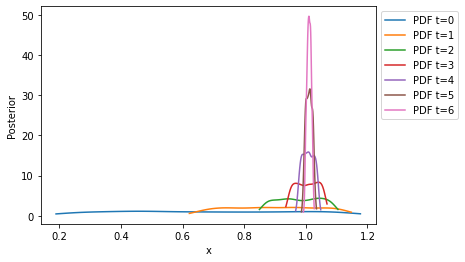

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='fitness', ylabel='Posterior'>)

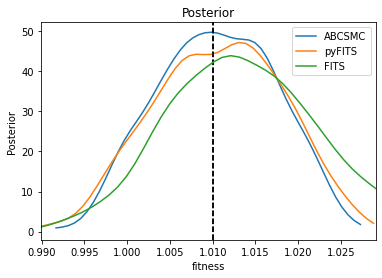

In [48]:
compare_fitness_inference(1.01)

Creating dataset...
running pyFits...
pyFITS run time  40.06
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.002340799999999997
Running FITS...


INFO:History:Start <ABCSMC(id=161, start_time=2021-02-09 16:01:20.205184, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  2.76
FITS max distance:  0.00398372
pyFITS max distance:  0.002340799999999997
Running SMC with epsilon:  0.002340799999999997


INFO:Epsilon:initial epsilon is 0.0416794
INFO:ABC:t: 0, eps: 0.0416794.
INFO:ABC:Acceptance rate: 1000 / 1980 = 5.0505e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.031909399999999984.
INFO:ABC:Acceptance rate: 1000 / 2003 = 4.9925e-01, ESS=9.9562e+02.
INFO:ABC:t: 2, eps: 0.019369288614683008.
INFO:ABC:Acceptance rate: 1000 / 1932 = 5.1760e-01, ESS=9.9824e+02.
INFO:ABC:t: 3, eps: 0.010490048839420526.
INFO:ABC:Acceptance rate: 1000 / 2010 = 4.9751e-01, ESS=9.9764e+02.
INFO:ABC:t: 4, eps: 0.005394384216943654.
INFO:ABC:Acceptance rate: 1000 / 1952 = 5.1230e-01, ESS=9.9557e+02.
INFO:ABC:t: 5, eps: 0.0029448000000000005.
INFO:ABC:Acceptance rate: 1000 / 2022 = 4.9456e-01, ESS=9.9792e+02.
INFO:ABC:t: 6, eps: 0.0019792117796101037.
INFO:ABC:Acceptance rate: 1000 / 2141 = 4.6707e-01, ESS=9.7487e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=161, start_time=2021-02-09 16:01:20.205184, end_time=2021-02-09 16:01:46.857294)>


SMC run time:  26.68
Total number of SMC simulations:  15040


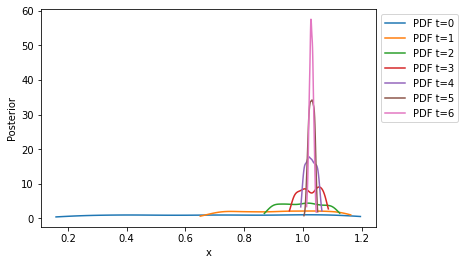

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='fitness', ylabel='Posterior'>)

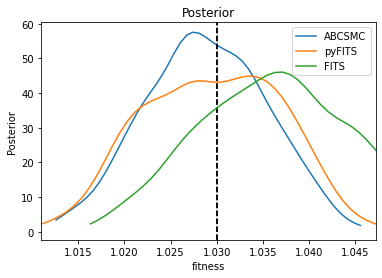

In [47]:
compare_fitness_inference(1.03)

Creating dataset...
running pyFits...
pyFITS run time  37.84
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.002873599999999998
Running FITS...


INFO:History:Start <ABCSMC(id=160, start_time=2021-02-09 16:00:09.130731, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  2.86
FITS max distance:  0.00528494
pyFITS max distance:  0.002873599999999998
Running SMC with epsilon:  0.002873599999999998


INFO:Epsilon:initial epsilon is 0.05502239999999998
INFO:ABC:t: 0, eps: 0.05502239999999998.
INFO:ABC:Acceptance rate: 1000 / 2008 = 4.9801e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.04303239999999996.
INFO:ABC:Acceptance rate: 1000 / 2089 = 4.7870e-01, ESS=9.9320e+02.
INFO:ABC:t: 2, eps: 0.027807347174060245.
INFO:ABC:Acceptance rate: 1000 / 2025 = 4.9383e-01, ESS=9.9856e+02.
INFO:ABC:t: 3, eps: 0.014744448545689223.
INFO:ABC:Acceptance rate: 1000 / 1956 = 5.1125e-01, ESS=9.9730e+02.
INFO:ABC:t: 4, eps: 0.007606037260453522.
INFO:ABC:Acceptance rate: 1000 / 1900 = 5.2632e-01, ESS=9.9931e+02.
INFO:ABC:t: 5, eps: 0.0040710898339686155.
INFO:ABC:Acceptance rate: 1000 / 2003 = 4.9925e-01, ESS=9.9945e+02.
INFO:ABC:t: 6, eps: 0.0025641169132482582.
INFO:ABC:Acceptance rate: 1000 / 1989 = 5.0277e-01, ESS=9.9261e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=160, start_time=2021-02-09 16:00:09.130731, end_time=2021-02-09 16:00:35.135361)>


SMC run time:  26.03
Total number of SMC simulations:  14970


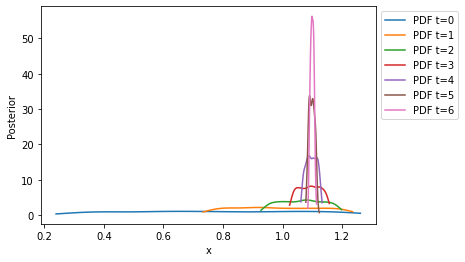

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='fitness', ylabel='Posterior'>)

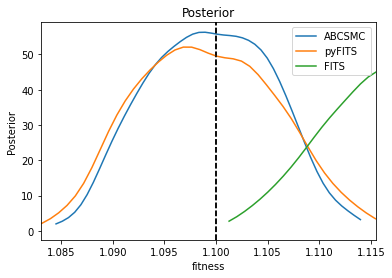

In [46]:
compare_fitness_inference(1.1)

## Comparing between FITS and SMC with fitness = 1

In [ ]:
compare_pyFITS(0.005, [-7,-2], 100000, 0.01)

In [ ]:
compare_pyFITS(0.0001, [-7,-2], 100000, 0.01)

In [ ]:
compare_pyFITS(0.00003, [-7,-2], 100000, 0.01)

In [ ]:
compare_pyFITS(0.000002, [-7,-2], 100000, 0.01)

In [ ]:
compare_pyFITS(0.0000003, [-7,-2], 100000, 0.01)

## And with fitness = 1.01

### Choosing reasonable values:

In [ ]:
pop_size = 100000000
gen_num = 10
fitness = 1
mutation_rate = 0.0007
sample_size = 100000
intial_freq = 0.8
data = simulate_50(generations_number=gen_num, wt_freq=intial_freq, population_size=pop_size,
                             fitness=fitness, mutation_rate=mutation_rate, sequence_sample_size=sample_size, 
                             color='black').mean()
fitness = 1.01
data = simulate_50(generations_number=gen_num, wt_freq=intial_freq, population_size=pop_size,
                             fitness=fitness, mutation_rate=mutation_rate, sequence_sample_size=sample_size, 
                             color='orange').mean()


In [ ]:
compare_pyFITS(0.0007, params_file='../FITS/params_fit.txt', fitness=1.01)

In [ ]:
THE END!